In [1]:
import pandas as pd
from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.stats import pearsonr
from scipy import stats

### Read Data

In [3]:
excel_file_path = r"/Users/evelynxu/Desktop/capstone/RC Projection data since 2022 28AUG24.xlsx"

excel_file = pd.ExcelFile(excel_file_path)
sheets_to_load = ['2022', '2023', '2024', 'Workday Calendar', 'Location hierarchy', 'Fleet Count']

dfs = {}

for sheet in tqdm(sheets_to_load, desc="Loading sheets"):
    dfs[sheet] = pd.read_excel(excel_file, sheet_name=sheet)

df_2022 = dfs['2022']
df_2023 = dfs['2023']
df_2024 = dfs['2024']
workday_calendar = dfs['Workday Calendar']
location_df = dfs['Location hierarchy']
fleet_count = dfs['Fleet Count']

print(df_2022.head())
print(df_2023.head())
print(df_2024.tail())

Loading sheets: 100%|█████████████████████████████| 6/6 [00:56<00:00,  9.47s/it]

       MONTH       YEAR GL_TRANSACTION_EFFECTIVE_DT  GL_EFF_WD_NBR  \
0 2022-01-01 2022-01-01                  2022-01-02              0   
1 2022-01-01 2022-01-01                  2022-01-02              0   
2 2022-01-01 2022-01-01                  2022-01-02              0   
3 2022-01-01 2022-01-01                  2022-01-02              0   
4 2022-01-01 2022-01-01                  2022-01-02              0   

    FIN_SOURCE_TYPE_DESC  LOCATION_CD       LOCATION_DESC  \
0  INTERDISTRICT BILLING          514              TUPELO   
1  INTERDISTRICT BILLING         1554           MANSFIELD   
2  INTERDISTRICT BILLING           30         LANDOVER MD   
3  INTERDISTRICT BILLING          284  BRIDGETON MISSOURI   
4  INTERDISTRICT BILLING         1278          SANFORD NC   

                  BU_DESC          REGION_DESC  TRANSACTION_AMOUNT  
0     OPS - MID SOUTH BU     OPS-SOUTH REGION                 52.0  
1   OPS - GREAT LAKES BU     OPS-NORTH REGION                 52.0  
2    

In [5]:
fin_source_types = df_2022['FIN_SOURCE_TYPE_DESC'].unique()
print(fin_source_types)
fin_source_types = df_2023['FIN_SOURCE_TYPE_DESC'].unique()
print(fin_source_types)
fin_source_types = df_2024['FIN_SOURCE_TYPE_DESC'].unique()
print(fin_source_types)

['INTERDISTRICT BILLING' 'WARRANTY CLAIMS' 'ELECTRONIC INVOICES'
 'RYDER FUEL' 'WALKER ACCOUNTS PAYABLE' 'FUEL JOURNALS' 'UNKNOWN'
 'WALKER ACCOUNT RECEIVABLE' 'REPAIR ORDERS' 'JOURNAL VOUCHERS' 'REVENUE'
 'CREDIT JOURNALS FROM FIS' 'CAPITALIZATION WRITE OFFS'
 'DISTRICT JOURNAL VOUCHERS' 'FLEET ANALYSIS' 'VEHICLE ADMIN MISC ENTRY'
 'SALES JOURNALS']
['REPAIR ORDERS' 'UNKNOWN' 'WARRANTY CLAIMS' 'JOURNAL VOUCHERS'
 'RYDER FUEL' 'FUEL JOURNALS' 'WALKER ACCOUNTS PAYABLE'
 'ELECTRONIC INVOICES' 'WALKER ACCOUNT RECEIVABLE'
 'CREDIT JOURNALS FROM FIS' 'CAPITALIZATION WRITE OFFS'
 'INTERDISTRICT BILLING' 'DISTRICT JOURNAL VOUCHERS' 'REVENUE'
 'SALES JOURNALS' 'FLEET ANALYSIS' 'VEHICLE ADMIN MISC ENTRY']
['UNKNOWN' 'WALKER ACCOUNTS PAYABLE' 'FUEL JOURNALS' 'WARRANTY CLAIMS'
 'RYDER FUEL' 'WALKER ACCOUNT RECEIVABLE' 'JOURNAL VOUCHERS'
 'REPAIR ORDERS' 'ELECTRONIC INVOICES' 'CREDIT JOURNALS FROM FIS'
 'DISTRICT JOURNAL VOUCHERS' 'INTERDISTRICT BILLING' 'REVENUE'
 'FLEET ANALYSIS' 'CAPITALIZATION

### Data Cleanning

In [5]:
df_2022['TRANSACTION_AMOUNT'] = pd.to_numeric(df_2022['TRANSACTION_AMOUNT'], errors='coerce')
df_2023['TRANSACTION_AMOUNT'] = pd.to_numeric(df_2023['TRANSACTION_AMOUNT'], errors='coerce')
df_2024['TRANSACTION_AMOUNT'] = pd.to_numeric(df_2024['TRANSACTION_AMOUNT'], errors='coerce')

df_2022.dropna(subset=['TRANSACTION_AMOUNT'], inplace=True)
df_2023.dropna(subset=['TRANSACTION_AMOUNT'], inplace=True)
df_2024.dropna(subset=['TRANSACTION_AMOUNT'], inplace=True)

print(df_2024.tail())

            MONTH       YEAR GL_TRANSACTION_EFFECTIVE_DT  GL_EFF_WD_NBR  \
304240 2024-08-01 2024-01-01                  2024-08-27             19   
304241 2024-08-01 2024-01-01                  2024-08-27             19   
304242 2024-08-01 2024-01-01                  2024-08-27             19   
304243 2024-08-01 2024-01-01                  2024-08-27             19   
304244 2024-08-01 2024-01-01                  2024-08-27             19   

       FIN_SOURCE_TYPE_DESC  LOCATION_CD       LOCATION_DESC  \
304240        REPAIR ORDERS          240      RICHMOND SOUTH   
304241        REPAIR ORDERS          919          SPRINGHILL   
304242        REPAIR ORDERS          226      WEST BALTIMORE   
304243              UNKNOWN         1016  SOUTH JACKSONVILLE   
304244        REPAIR ORDERS          421        GREENBAY WIS   

                        BU_DESC          REGION_DESC  TRANSACTION_AMOUNT  ...  \
304240            OPS - DMV BU     OPS-NORTH REGION              8859.09  ...   
30

In [ ]:
df_2022['MONTH'] = pd.to_datetime(df_2022['MONTH']).dt.month
df_2023['MONTH'] = pd.to_datetime(df_2023['MONTH']).dt.month
df_2024['MONTH'] = pd.to_datetime(df_2024['MONTH']).dt.month

grouped_2022 = df_2022.groupby(['YEAR', 'MONTH', 'FIN_SOURCE_TYPE_DESC'])['TRANSACTION_AMOUNT'].sum().reset_index()
grouped_2023 = df_2023.groupby(['YEAR', 'MONTH', 'FIN_SOURCE_TYPE_DESC'])['TRANSACTION_AMOUNT'].sum().reset_index()
grouped_2024 = df_2024.groupby(['YEAR', 'MONTH', 'FIN_SOURCE_TYPE_DESC'])['TRANSACTION_AMOUNT'].sum().reset_index()

In [9]:
#compare grouped and original
monthly_sum_2022 = df_2022.groupby(['YEAR', 'MONTH'])['TRANSACTION_AMOUNT'].sum().reset_index()
monthly_sum_2023 = df_2023.groupby(['YEAR', 'MONTH'])['TRANSACTION_AMOUNT'].sum().reset_index()

grouped_monthly_sum_2022 = grouped_2022.groupby(['YEAR', 'MONTH'])['TRANSACTION_AMOUNT'].sum().reset_index()
grouped_monthly_sum_2023 = grouped_2023.groupby(['YEAR', 'MONTH'])['TRANSACTION_AMOUNT'].sum().reset_index()

comparison_2022 = pd.merge(monthly_sum_2022, grouped_monthly_sum_2022, on=['YEAR', 'MONTH'], suffixes=('_original', '_grouped'))
comparison_2022['is_equal'] = comparison_2022['TRANSACTION_AMOUNT_original'] == comparison_2022['TRANSACTION_AMOUNT_grouped']

comparison_2023 = pd.merge(monthly_sum_2023, grouped_monthly_sum_2023, on=['YEAR', 'MONTH'], suffixes=('_original', '_grouped'))
comparison_2023['is_equal'] = comparison_2023['TRANSACTION_AMOUNT_original'] == comparison_2023['TRANSACTION_AMOUNT_grouped']

print(comparison_2022[['YEAR', 'MONTH', 'TRANSACTION_AMOUNT_original', 'TRANSACTION_AMOUNT_grouped', 'is_equal']])
print(comparison_2023[['YEAR', 'MONTH', 'TRANSACTION_AMOUNT_original', 'TRANSACTION_AMOUNT_grouped', 'is_equal']])

         YEAR  MONTH  TRANSACTION_AMOUNT_original  TRANSACTION_AMOUNT_grouped  \
0  2022-01-01      1                  70390607.48                 70390607.48   
1  2022-01-01      2                  72489588.75                 72489588.75   
2  2022-01-01      3                  83814448.39                 83814448.39   
3  2022-01-01      4                  72421257.02                 72421257.02   
4  2022-01-01      5                  77575062.02                 77575062.02   
5  2022-01-01      6                  79356975.03                 79356975.03   
6  2022-01-01      7                  77579995.06                 77579995.06   
7  2022-01-01      8                  86969476.53                 86969476.53   
8  2022-01-01      9                  81618954.94                 81618954.94   
9  2022-01-01     10                  81557584.03                 81557584.03   
10 2022-01-01     11                  74016929.50                 74016929.50   
11 2022-01-01     12        

###  Train Data 2022 + 2023 

In [ ]:
train_data = pd.concat([grouped_2022, grouped_2023])

train_data['YEAR'] = train_data['YEAR'].astype(str).str.slice(0, 4).astype(int)
train_data['MONTH'] = train_data['MONTH'].astype(str).str.zfill(2)

#train_data['DATE'] = pd.to_datetime(train_data['YEAR'] + '-' + train_data['MONTH'], format='%Y-%m', errors='coerce')
print(train_data.head())

# YEAR_MONTH - "YYYY-MM"
train_data['YEAR_MONTH'] = train_data['YEAR'] + '-' + train_data['MONTH']

   YEAR MONTH       FIN_SOURCE_TYPE_DESC  TRANSACTION_AMOUNT
0  2022    01  CAPITALIZATION WRITE OFFS           174973.34
1  2022    01   CREDIT JOURNALS FROM FIS          2885793.63
2  2022    01  DISTRICT JOURNAL VOUCHERS             1551.00
3  2022    01        ELECTRONIC INVOICES         35006490.71
4  2022    01             FLEET ANALYSIS         14577904.96


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('int64'), dtype('<U1')) -> None

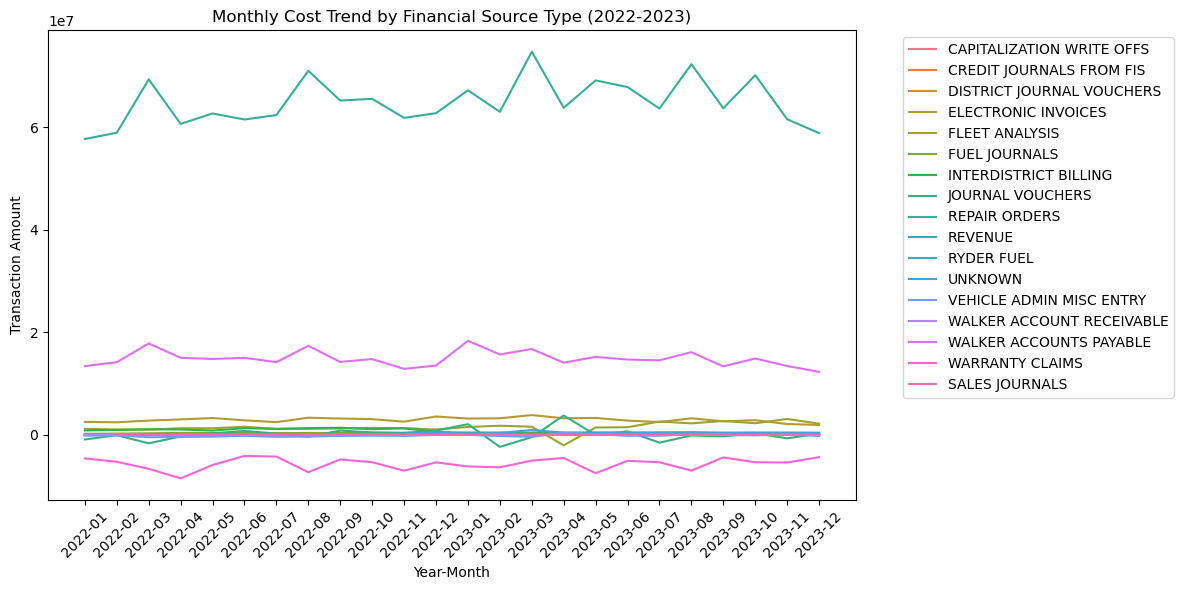

In [33]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=train_data, x='YEAR_MONTH', y='TRANSACTION_AMOUNT', hue='FIN_SOURCE_TYPE_DESC')
plt.title('Monthly Cost Trend by Financial Source Type (2022-2023)')
plt.xlabel('Year-Month')
plt.ylabel('Transaction Amount')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.tight_layout()  
plt.show()

### Test Data 2024

In [37]:
test_data = pd.concat([grouped_2024])

test_data['YEAR'] = test_data['YEAR'].astype(str).astype(str).str.slice(0, 4).astype(int)
test_data['MONTH'] = test_data['MONTH'].astype(str).str.zfill(2)

test_data['YEAR'] = test_data['YEAR'].astype(str).str.slice(0, 4)
test_data['MONTH'] = test_data['MONTH'].astype(str).str.zfill(2)

# YEAR_MONTH - "YYYY-MM"
test_data['YEAR_MONTH'] = test_data['YEAR'] + '-' + test_data['MONTH']

     YEAR MONTH       FIN_SOURCE_TYPE_DESC  TRANSACTION_AMOUNT
127  2024    08                    UNKNOWN           549097.84
128  2024    08   VEHICLE ADMIN MISC ENTRY           -89973.27
129  2024    08  WALKER ACCOUNT RECEIVABLE            43348.76
130  2024    08    WALKER ACCOUNTS PAYABLE         11808900.71
131  2024    08            WARRANTY CLAIMS         -3902136.88
   YEAR MONTH       FIN_SOURCE_TYPE_DESC  TRANSACTION_AMOUNT
0  2024    01  CAPITALIZATION WRITE OFFS             3950.83
1  2024    01   CREDIT JOURNALS FROM FIS           402930.95
2  2024    01  DISTRICT JOURNAL VOUCHERS            -2498.20
3  2024    01        ELECTRONIC INVOICES          1884829.37
4  2024    01             FLEET ANALYSIS          2213236.28


### Linear Regression

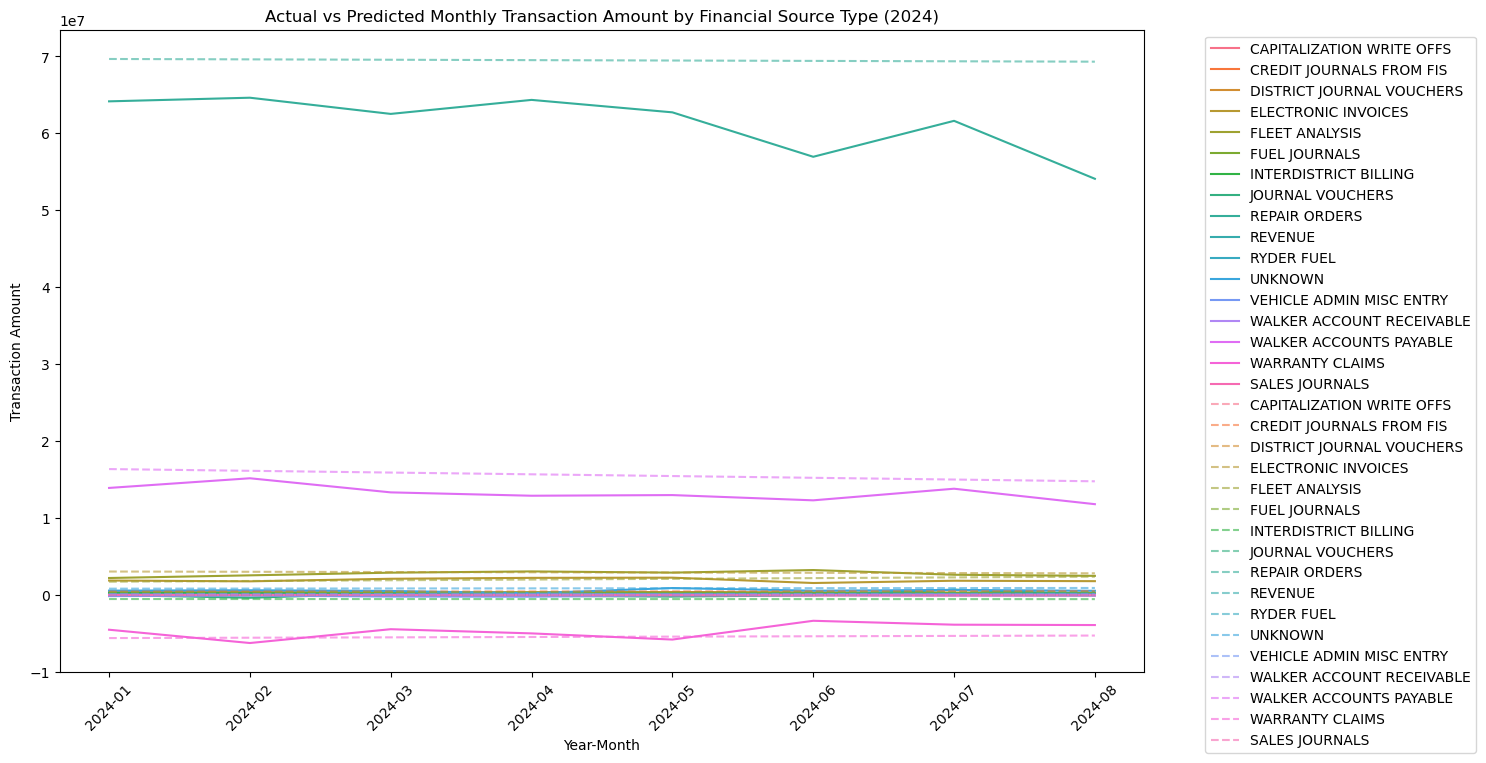

In [39]:
financial_sources = train_data['FIN_SOURCE_TYPE_DESC'].unique()
predictions = []

for source in financial_sources:
    train_source = train_data[train_data['FIN_SOURCE_TYPE_DESC'] == source]
    test_source = test_data[test_data['FIN_SOURCE_TYPE_DESC'] == source]

    X_train = train_source[['YEAR', 'MONTH']].astype(int)
    y_train = train_source['TRANSACTION_AMOUNT']
    X_test = test_source[['YEAR', 'MONTH']].astype(int)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    test_source = test_source.copy() 
    test_source['PREDICTED_AMOUNT'] = y_pred
    predictions.append(test_source)

predictions_df = pd.concat(predictions)

plt.figure(figsize=(15, 8))
sns.lineplot(data=predictions_df, x='YEAR_MONTH', y='TRANSACTION_AMOUNT', hue='FIN_SOURCE_TYPE_DESC', linestyle='-')
sns.lineplot(data=predictions_df, x='YEAR_MONTH', y='PREDICTED_AMOUNT', hue='FIN_SOURCE_TYPE_DESC', linestyle='--', alpha=0.6)
plt.title('Actual vs Predicted Monthly Transaction Amount by Financial Source Type (2024)')
plt.xlabel('Year-Month')
plt.ylabel('Transaction Amount')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


predictions_df['YEAR'] = predictions_df['YEAR'].astype(int)
predictions_df['MONTH'] = predictions_df['MONTH'].astype(int)

print("Unique YEAR values:", predictions_df['YEAR'].unique())
print("Unique MONTH values:", predictions_df['MONTH'].unique())

# Sum up the predicted values for each financial source, month in 2024
predicted_total_2024 = predictions_df[predictions_df['YEAR'] == 2024].groupby(['YEAR', 'MONTH', 'FIN_SOURCE_TYPE_DESC'])['PREDICTED_AMOUNT'].sum().reset_index()
actual_total_2024 = predictions_df[predictions_df['YEAR'] == 2024].groupby(['YEAR', 'MONTH', 'FIN_SOURCE_TYPE_DESC'])['TRANSACTION_AMOUNT'].sum().reset_index()

comparison_2024 = pd.merge(actual_total_2024, predicted_total_2024, on=['YEAR', 'MONTH', 'FIN_SOURCE_TYPE_DESC'], suffixes=('_actual', '_predicted'))
comparison_2024.dropna(subset=['TRANSACTION_AMOUNT', 'PREDICTED_AMOUNT'], inplace=True)

# RMSE, MSE, MAE
rmse = np.sqrt(mean_squared_error(comparison_2024['TRANSACTION_AMOUNT'], comparison_2024['PREDICTED_AMOUNT']))
mse = mean_squared_error(comparison_2024['TRANSACTION_AMOUNT'], comparison_2024['PREDICTED_AMOUNT'])
mae = mean_absolute_error(comparison_2024['TRANSACTION_AMOUNT'], comparison_2024['PREDICTED_AMOUNT'])

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

Unique YEAR values: [2024]
Unique MONTH values: [1 2 3 4 5 6 7 8]
RMSE: 2302761.372974563
MSE: 5302709940863.693
MAE: 899245.849248521


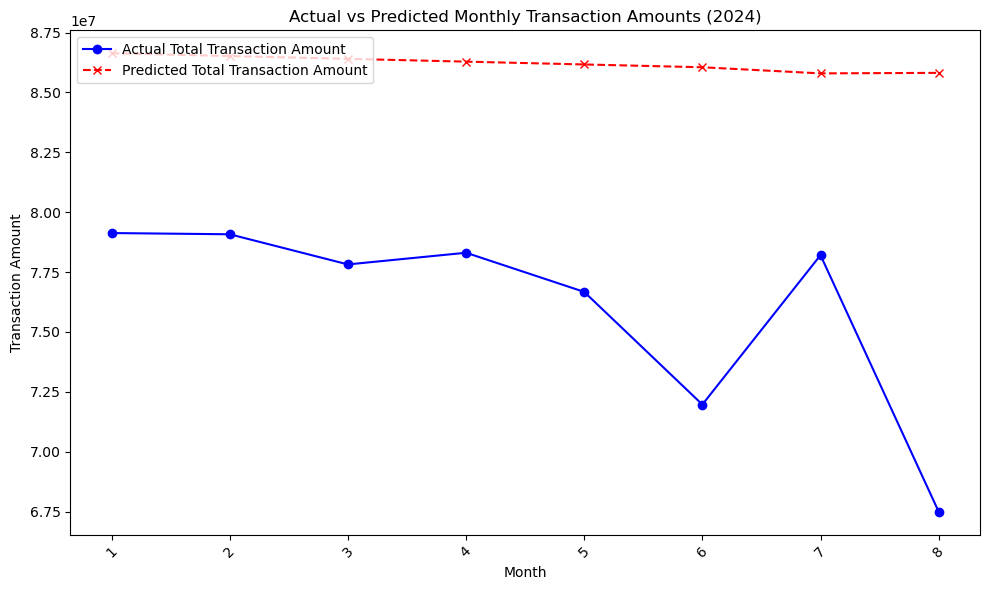

In [65]:
import matplotlib.pyplot as plt

monthly_actual_total = comparison_2024.groupby('MONTH')['TRANSACTION_AMOUNT'].sum()
monthly_predicted_total = comparison_2024.groupby('MONTH')['PREDICTED_AMOUNT'].sum()

plt.figure(figsize=(10, 6))
plt.plot(monthly_actual_total.index, monthly_actual_total, label='Actual Total Transaction Amount', color='blue', linestyle='-', marker='o')
plt.plot(monthly_predicted_total.index, monthly_predicted_total, label='Predicted Total Transaction Amount', color='red', linestyle='--', marker='x')
plt.title('Actual vs Predicted Monthly Transaction Amounts (2024)')
plt.xlabel('Month')
plt.ylabel('Transaction Amount')
plt.xticks(ticks=monthly_actual_total.index, labels=monthly_actual_total.index.astype(str), rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [69]:
# MSE、RMSE、MAE R^2 for each financial source with linear regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np  

for source in financial_sources:
    source_data = predictions_df[predictions_df['FIN_SOURCE_TYPE_DESC'] == source]
    y_true = source_data['TRANSACTION_AMOUNT']
    y_pred = source_data['PREDICTED_AMOUNT']
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f'Financial Source: {source}')
    print(f'Mean Squared Error (MSE): {mse:.2f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
    print(f'Mean Absolute Error (MAE): {mae:.2f}')
    print(f'R^2 Score: {r2:.2f}')
    print('-' * 30)

Financial Source: CAPITALIZATION WRITE OFFS
Mean Squared Error (MSE): 1515582938.10
Root Mean Squared Error (RMSE): 38930.49
Mean Absolute Error (MAE): 38121.69
R^2 Score: -32.90
------------------------------
Financial Source: CREDIT JOURNALS FROM FIS
Mean Squared Error (MSE): 18858165399.19
Root Mean Squared Error (RMSE): 137325.04
Mean Absolute Error (MAE): 126887.35
R^2 Score: -11.81
------------------------------
Financial Source: DISTRICT JOURNAL VOUCHERS
Mean Squared Error (MSE): 13782631.54
Root Mean Squared Error (RMSE): 3712.50
Mean Absolute Error (MAE): 2904.27
R^2 Score: 0.00
------------------------------
Financial Source: ELECTRONIC INVOICES
Mean Squared Error (MSE): 1055767475392.83
Root Mean Squared Error (RMSE): 1027505.46
Mean Absolute Error (MAE): 1002968.79
R^2 Score: -19.45
------------------------------
Financial Source: FLEET ANALYSIS
Mean Squared Error (MSE): 592749111371.87
Root Mean Squared Error (RMSE): 769902.01
Mean Absolute Error (MAE): 695698.63
R^2 Score

### ARIMA

In [77]:
from statsmodels.tsa.arima.model import ARIMA

train_data_agg = train_data.groupby(['YEAR_MONTH'])['TRANSACTION_AMOUNT'].sum().reset_index()
train_data_agg['YEAR_MONTH'] = pd.to_datetime(train_data_agg['YEAR_MONTH'])
train_data_agg.set_index('YEAR_MONTH', inplace=True)

test_data_agg = test_data.groupby(['YEAR_MONTH'])['TRANSACTION_AMOUNT'].sum().reset_index()
test_data_agg['YEAR_MONTH'] = pd.to_datetime(test_data_agg['YEAR_MONTH'])
test_data_agg.set_index('YEAR_MONTH', inplace=True)

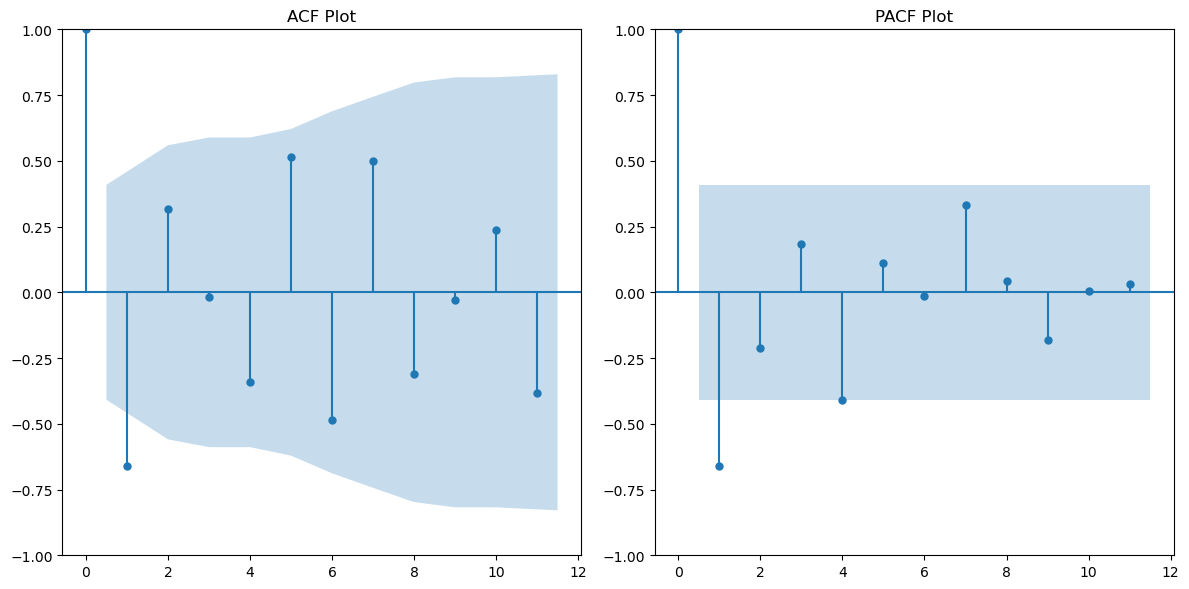

In [81]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

series_diff = train_data_agg['TRANSACTION_AMOUNT'].diff().dropna() 

max_lags = len(series_diff) // 2 

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(series_diff, ax=plt.gca(), lags=max_lags)  
plt.title("ACF Plot")

plt.subplot(122)
plot_pacf(series_diff, ax=plt.gca(), lags=max_lags)  
plt.title("PACF Plot")

plt.tight_layout()
plt.show()

RMSE: 5846709.09232924
MSE: 34184007210325.414
MAE: 5408837.315555027


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


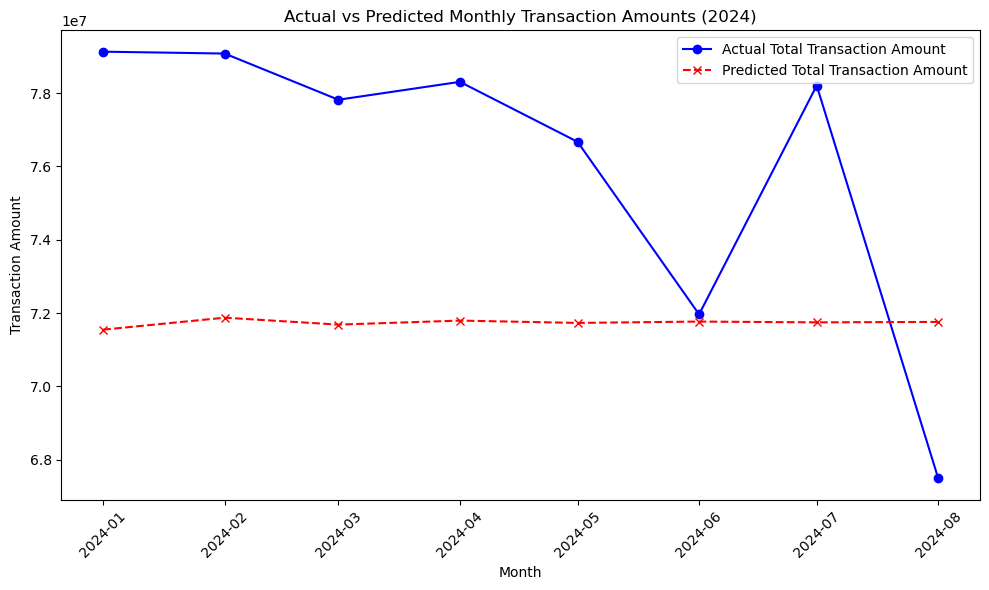

In [85]:
model = ARIMA(train_data_agg['TRANSACTION_AMOUNT'], order=(1, 1, 1)) 
model_fit = model.fit()

forecast = model_fit.forecast(steps=len(test_data_agg))

comparison_df = test_data_agg.copy()
comparison_df['PREDICTED_AMOUNT'] = forecast.values

rmse = np.sqrt(mean_squared_error(comparison_df['TRANSACTION_AMOUNT'], comparison_df['PREDICTED_AMOUNT']))
mse = mean_squared_error(comparison_df['TRANSACTION_AMOUNT'], comparison_df['PREDICTED_AMOUNT'])
mae = mean_absolute_error(comparison_df['TRANSACTION_AMOUNT'], comparison_df['PREDICTED_AMOUNT'])

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

plt.figure(figsize=(10, 6))
plt.plot(comparison_df.index, comparison_df['TRANSACTION_AMOUNT'], label='Actual Total Transaction Amount', color='blue', marker='o')
plt.plot(comparison_df.index, comparison_df['PREDICTED_AMOUNT'], label='Predicted Total Transaction Amount', color='red', linestyle='--', marker='x')
plt.title('Actual vs Predicted Monthly Transaction Amounts (2024)')
plt.xlabel('Month')
plt.ylabel('Transaction Amount')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### NN

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

nn_train_data = pd.concat([grouped_2022, grouped_2023])
nn_test_data = grouped_2024

# One-Hot Encoding FIN_SOURCE_TYPE_DESC
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(nn_train_data[['FIN_SOURCE_TYPE_DESC']])

nn_train_features = pd.concat([
    nn_train_data[['MONTH']].reset_index(drop=True),
    pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['FIN_SOURCE_TYPE_DESC']))
], axis=1)

encoded_test_features = encoder.transform(nn_test_data[['FIN_SOURCE_TYPE_DESC']])
nn_test_features = pd.concat([
    nn_test_data[['MONTH']].reset_index(drop=True),
    pd.DataFrame(encoded_test_features, columns=encoder.get_feature_names_out(['FIN_SOURCE_TYPE_DESC']))
], axis=1)

nn_y_train = nn_train_data['TRANSACTION_AMOUNT'].values
nn_y_test = nn_test_data['TRANSACTION_AMOUNT'].values

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(nn_train_features)
X_test_scaled = scaler.transform(nn_test_features)

In [ ]:
print(nn_y_train)
print(nn_y_test)

[ 1.74973340e+05  2.88579363e+06  1.55100000e+03  3.50064907e+07
  1.45779050e+07  3.85897471e+06  1.27781245e+07  3.69198570e+05
  7.59934581e+08  3.52087820e+05  1.71129530e+05 -1.21000000e+04
  4.64732800e+05 -3.08279376e+06  3.27319960e+05  1.77205016e+08
 -6.91422714e+07  3.02781020e+05  4.38837777e+06  8.48200000e+02
  3.47407120e+07  2.07599076e+07  4.06132603e+06  3.20477124e+06
  1.49399092e+06  7.96371395e+08  4.79528320e+05  1.50238140e+05
 -9.62000000e+04  5.61660802e+06 -7.32448050e+05  3.86001750e+05
  1.79344948e+08 -6.65950947e+07]
[ 3.81438000e+04  2.79658955e+06 -2.49820000e+03  1.54865842e+07
  2.20312166e+07  2.40162423e+06  8.37386380e+05  2.86481170e+05
  4.91142451e+08  4.20853050e+05  7.05973300e+04 -1.76000000e+05
  4.62185334e+06 -8.10881000e+05  3.16077210e+05  1.06270385e+08
 -3.70723647e+07]


In [ ]:
mlp = MLPRegressor(hidden_layer_sizes=(100,100, 50), activation='relu', solver='adam', max_iter=2000, random_state=42, learning_rate_init=0.01)

mlp.fit(X_train_scaled, nn_y_train)

nn_y_pred = mlp.predict(X_test_scaled)

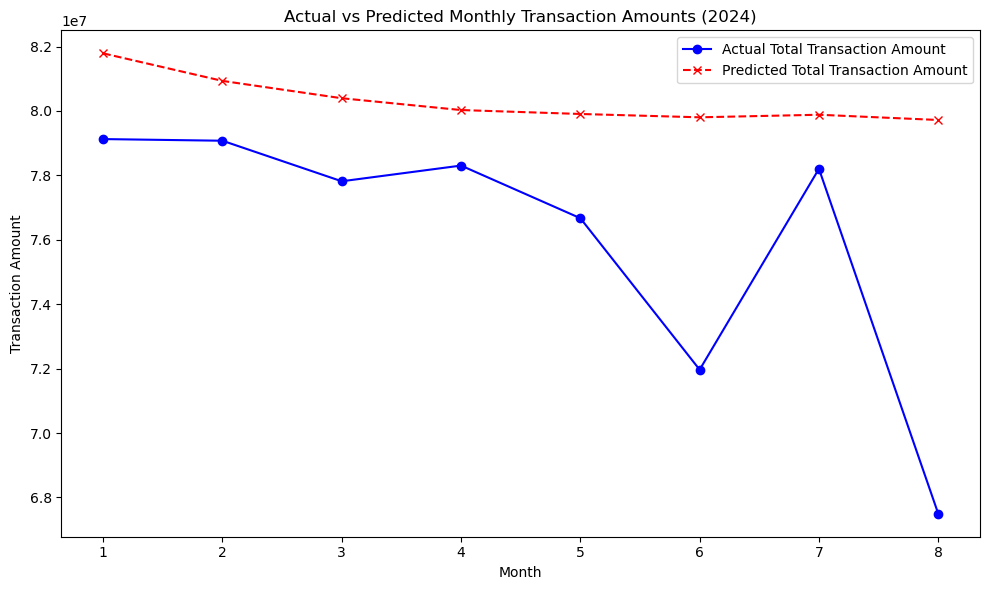

In [126]:
actual_total_2024 = nn_test_data.copy()
actual_total_2024['TRANSACTION_AMOUNT'] = nn_y_test
actual_monthly_sum = actual_total_2024.groupby('MONTH')['TRANSACTION_AMOUNT'].sum().reset_index()

predicted_total_2024 = nn_test_data.copy()
predicted_total_2024['TRANSACTION_AMOUNT'] = nn_y_pred
predicted_monthly_sum = predicted_total_2024.groupby('MONTH')['TRANSACTION_AMOUNT'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(actual_monthly_sum['MONTH'], actual_monthly_sum['TRANSACTION_AMOUNT'], label='Actual Total Transaction Amount', color='blue', marker='o')
plt.plot(predicted_monthly_sum['MONTH'], predicted_monthly_sum['TRANSACTION_AMOUNT'], label='Predicted Total Transaction Amount', color='red', linestyle='--', marker='x')
plt.title('Actual vs Predicted Monthly Transaction Amounts (2024)')
plt.xlabel('Month')
plt.ylabel('Transaction Amount')
plt.xticks(ticks=actual_monthly_sum['MONTH'], labels=actual_monthly_sum['MONTH'])
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
print(predicted_monthly_sum['TRANSACTION_AMOUNT'])

NameError: name 'predicted_monthly_sum' is not defined